In [1]:
%matplotlib inline


In [29]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from lightkurve import TessLightCurveFile
from astropy.coordinates import SkyCoord
import astropy.units as u
import lightkurve

import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt
from astropy.stats import BoxLeastSquares


In [30]:
target = 'l 98-59'
lc = lightkurve.search_lightcurvefile(target).download()

In [31]:
texp = lc.hdu[1].header['FRAMETIM'] * lc.hdu[1].header["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0
ref_time = 0.5 * (lc.time.min() + lc.time.max())
# flux = tpf.flux

# pix_mask = tpf.create_threshold_mask(threshold=3)
# tpf.plot(aperture_mask=pix_mask, )
# plt.gcf().savefig('pixmask.pdf', dpi=200)

In [32]:
lc = lc.PDCSAP_FLUX

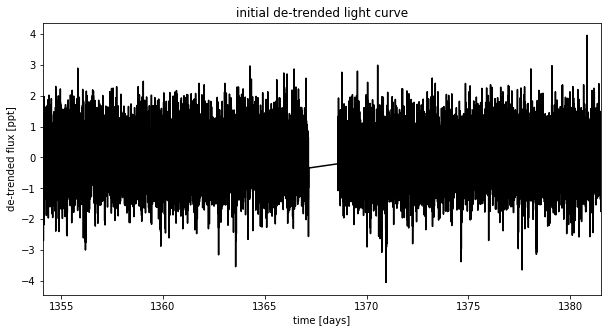

In [33]:
# lc = tpf.extract_aperture_photometry(aperture_mask=pix_mask, )
lc = lc.normalize()
lc.flux = (lc.flux - 1.0) * 1e3
# Build the first order PLD basis
# X_pld = np.reshape(flux[:, pix_mask], (len(flux), -1))
# X_pld = X_pld / np.sum(flux[:, pix_mask], axis=-1)[:, None]

# # Build the second order PLD basis and run PCA to reduce the number of dimensions
# X2_pld = np.reshape(X_pld[:, None, :] * X_pld[:, :, None], (len(flux), -1))
# U, _, _ = np.linalg.svd(X2_pld, full_matrices=False)
# X2_pld = U[:, :X_pld.shape[1]]

# # Construct the design matrix and fit for the PLD model
# X_pld = np.concatenate((np.ones((len(flux), 1)), X_pld, X2_pld), axis=-1)
# XTX = np.dot(X_pld.T, X_pld)
# w_pld = np.linalg.solve(XTX, np.dot(X_pld.T, lc.flux))
# pld_flux = np.dot(X_pld, w_pld)

# Plot the de-trended light curve
plt.figure(figsize=(10, 5))
plt.plot(lc.time, lc.flux, "k")
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("initial de-trended light curve")
plt.xlim(lc.time.min(), lc.time.max());

In [34]:
period_grid = np.exp(np.linspace(np.log(0.1), np.log(15), 50000))
duration = 0.03

bls_periods = np.zeros([3])
bls_t0s = np.zeros([3])
bls_depths = np.zeros([3])
time = lc.time - ref_time

# planet 1
bls = BoxLeastSquares(time, lc.flux)
bls_power = bls.power(period_grid, duration, oversample=20)

bls_power0 = bls_power

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = bls.transit_mask(time, bls_period, 3*duration, bls_t0)

bls_periods[0] = bls_period
bls_t0s[0] = bls_t0
bls_depths[0] = bls_depth

# planet 2
bls = BoxLeastSquares(time[~transit_mask], lc.flux[~transit_mask])
bls_power = bls.power(period_grid, duration, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = np.logical_or((transit_mask), (bls.transit_mask(time, bls_period, 3*duration, bls_t0)))

bls_periods[1] = bls_period
bls_t0s[1] = bls_t0
bls_depths[1] = bls_depth

# planet 3
bls = BoxLeastSquares(time[~transit_mask], lc.flux[~transit_mask])
bls_power = bls.power(period_grid, duration, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = np.logical_or((transit_mask), (bls.transit_mask(time, bls_period, 3*duration, bls_t0)))

bls_periods[2] = bls_period
bls_t0s[2] = bls_t0
bls_depths[2] = bls_depth


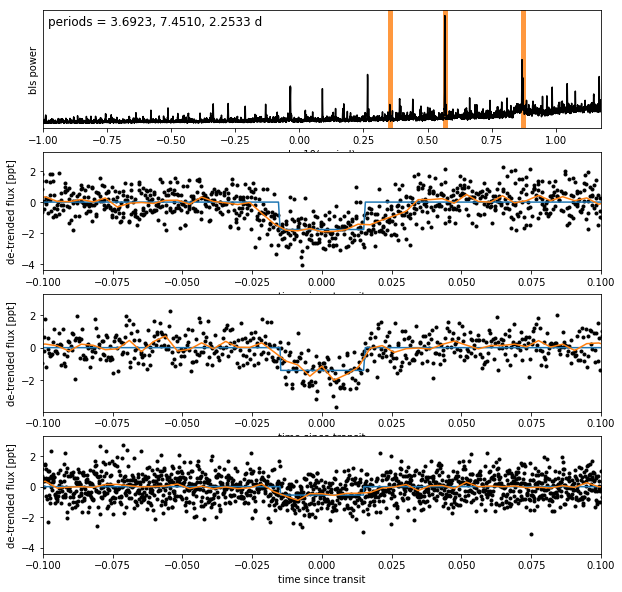

In [38]:
fig, axes = plt.subplots(4, 1, figsize=(10, 10))

# Plot the periodogram
ax = axes[0]
ax.axvline(np.log10(bls_periods[0]), color="C1", lw=5, alpha=0.8)
ax.axvline(np.log10(bls_periods[1]), color="C1", lw=5, alpha=0.8)
ax.axvline(np.log10(bls_periods[2]), color="C1", lw=5, alpha=0.8)
ax.plot(np.log10(bls_power0.period), bls_power0.power, "k")
ax.annotate("periods = {0:.4f}, {1:.4f}, {2:.4f} d".format(*bls_periods),
            (0, 1), xycoords="axes fraction",
            xytext=(5, -5), textcoords="offset points",
            va="top", ha="left", fontsize=12)
ax.set_ylabel("bls power")
ax.set_yticks([])
ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
ax.set_xlabel("log10(period)")

# Plot the folded transits
bls = BoxLeastSquares(time, lc.flux)
for i in range(3):
    ax = axes[i+1]
    x_fold = (time - bls_t0s[i] + 0.5*bls_periods[i])%bls_periods[i] - 0.5*bls_periods[i]
    m = np.abs(x_fold) < 0.4
    ax.plot(x_fold[m], lc.flux[m], ".k")
    inds = np.argsort(x_fold[m])
    ax.plot(x_fold[m][inds], bls.model(time, bls_periods[i], duration, bls_t0s[i])[m][inds])

    # Overplot the phase binned light curve
    bins = np.linspace(-0.11, 0.11, 52)
    denom, _ = np.histogram(x_fold, bins)
    num, _ = np.histogram(x_fold, bins, weights=lc.flux)
    denom[num == 0] = 1.0
    ax.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1")

    ax.set_xlim(-0.1, 0.1)
    ax.set_ylabel("de-trended flux [ppt]")
    ax.set_xlabel("time since transit");

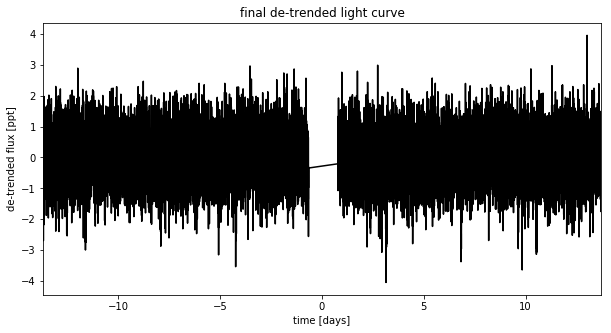

In [39]:
# m = ~transit_mask
# XTX = np.dot(X_pld[m].T, X_pld[m])
# w_pld = np.linalg.solve(XTX, np.dot(X_pld[m].T, lc.flux[m]))
# pld_flux = np.dot(X_pld, w_pld)

x = np.ascontiguousarray(lc.time-ref_time, dtype=np.float64)
y = np.ascontiguousarray(lc.flux, dtype=np.float64)

plt.figure(figsize=(10, 5))
plt.plot(x, y, "k")
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("final de-trended light curve")
plt.xlim(x.min(), x.max());



In [42]:
# plt.figure(figsize=(10, 5))

# x_fold = (x - bls_t0 + 0.5*bls_period) % bls_period - 0.5*bls_period
# m = np.abs(x_fold) < 0.3
# # plt.plot(x_fold[m], pld_flux[m], ".k", ms=4)

# bins = np.linspace(-0.5, 0.5, 60)
# denom, _ = np.histogram(x_fold, bins)
# # num, _ = np.histogram(x_fold, bins, weights=pld_flux)
# # denom[num == 0] = 1.0
# plt.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1", lw=2)
# plt.xlim(-0.2, 0.2)
# plt.xlabel("time since transit")
# plt.ylabel("PLD model flux");

In [43]:
def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.distributions.QuadLimbDark("u_star",
                                              testval=np.array([0.3, 0.2]))
        
        # Stellar parameters from Kostov et al (2018)
        R_star_kostov = 0.291, 0.025
#         M_star_kostov = 0.32, 0.025
        Rho_star_kostov = 18.0
#         m_star = pm.Normal("m_star", mu=M_star_kostov[0], sd=M_star_kostov[1])
        r_star = pm.Normal("r_star", mu=R_star_kostov[0], sd=R_star_kostov[1])

        logrho_star = pm.Normal("logrho_star", mu=np.log(Rho_star_kostov), sd=0.3)
        rho_star = pm.Deterministic("rho_star", tt.exp(logrho_star))

        # Prior to require physical parameters
#         pm.Potential("m_star_prior", tt.switch(m_star > 0, 0, -np.inf))
        pm.Potential("r_star_prior", tt.switch(r_star > 0, 0, -np.inf))
        pm.Potential("rho_star_prior", tt.switch(rho_star > 0, 0, -np.inf))

        # Orbital parameters for the planets
        logP = pm.Normal("logP", mu=np.log(bls_periods), sd=0.2, shape=3)
        t0 = pm.Normal("t0", mu=bls_t0s, sd=0.2, shape=3)
        logror = pm.Normal("logror", mu=np.log(np.sqrt(1e-3)*np.sqrt(bls_depths)),
                           sd=2, shape=3)
        ror = pm.Deterministic("r", tt.exp(logror))
        b_param = pm.Uniform("b_param", lower=0, upper=1, shape=3)
        b = pm.Deterministic("b", b_param * (1 + ror))
#         ror, b = xo.distributions.get_joint_radius_impact(
#             min_radius=0.01, max_radius=0.3,
#             testval_r=np.sqrt(1e-3)*np.sqrt(bls_depths),
#             testval_b=[0.1,0.8,0.1])
#         ecc = pm.Bound(pm.Beta, lower=0.0, upper=0.99)("ecc", alpha=0.867, beta=3.03,
#                                                        testval=[0.03,0.02,0.04], shape=3)
        ecc = pm.Beta('ecc', alpha=0.867, beta=3.03, testval=[0.03,0.02,0.04], shape=3)
        omega = xo.distributions.Angle("omega", shape=3)
        
        # Log-uniform prior on ror
        pm.Potential("ror_prior_lo", tt.switch(tt.all(0.005 < ror), 0.0, -np.inf))
        pm.Potential("ror_prior_hi", tt.switch(tt.all(ror < 0.3), 0.0, -np.inf))
#         pm.Potential("ror_prior", -tt.log(ror))

        # Transit jitter & GP parameters
        logs2 = pm.Normal("logs2", mu=np.log(np.var(y[mask])), sd=10)
        logS0 = pm.Normal("logS0", mu=np.log(np.var(y[mask])), sd=10)
        logw0 = pm.Normal("logw0", mu=np.log(2*np.pi/10), sd=10)

        # Tracking planet parameters
        period = pm.Deterministic("period", tt.exp(logP))
        r_pl = pm.Deterministic("r_pl", r_star * ror)
        r_ple = pm.Deterministic("r_ple", (r_star * ror / 0.009155))

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star, #m_star=m_star,
            period=period, t0=t0, b=b,
            ecc=ecc, omega=omega,
            rho_star=rho_star,
            )
        
        a = pm.Deterministic("a", orbit.a)
#         pm.Potential("ecc_prior", tt.switch((ecc < 1 - (1/a)), 0, -np.inf))

        # Compute the model light curve using starry
        light_curves = xo.StarryLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=x[mask], texp=texp)*1e3
        light_curve = pm.math.sum(light_curves, axis=-1)
        pm.Deterministic("light_curve", light_curve)
        model.light_curves = light_curves

        # GP model for the light curve
        kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
        gp = xo.gp.GP(kernel, x[mask], tt.exp(logs2) + tt.zeros(mask.sum()), J=2)
        pm.Potential("transit_obs", gp.log_likelihood(y[mask] - light_curve - mean))
        pm.Deterministic("gp_pred", gp.predict())

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = pm.find_MAP(start=start, vars=[logs2, logS0, logw0])
#         map_soln = pm.find_MAP(start=map_soln, vars=[model.rb])
        map_soln = pm.find_MAP(start=map_soln, vars=[model.logror, model.b_param])
        map_soln = pm.find_MAP(start=map_soln)

    return model, map_soln

model0, map_soln0 = build_model()

/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
  0%|          | 0/5000 [00:00<?, ?it/s]/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequ

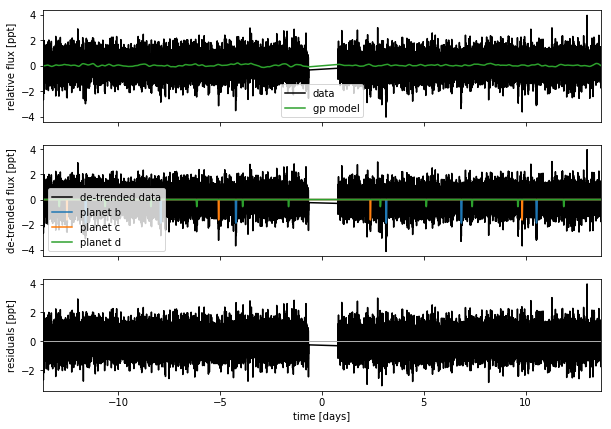

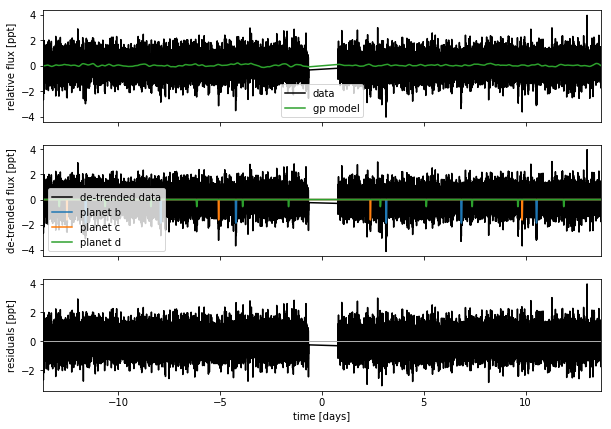

In [45]:
def plot_light_curve(model, soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = xo.utils.eval_in_model(model.gp_pred, soln, model=model)
    gp_mod += soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    light_curves = xo.utils.eval_in_model(model.light_curves, soln, model=model)
    for i, l in enumerate(["b", "c", 'd']):
        mod = light_curves[:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(light_curves, axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    
    return fig
    
plot_light_curve(model0, map_soln0)


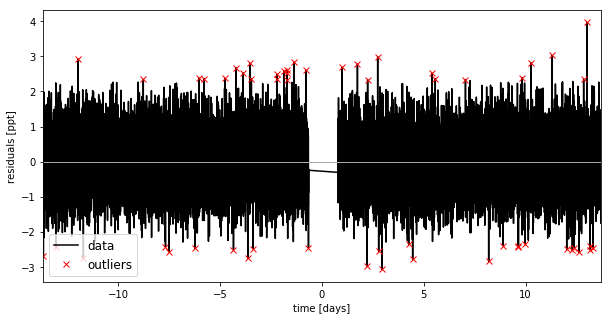

In [46]:
mod = map_soln0["gp_pred"] + map_soln0["mean"] + map_soln0["light_curve"]
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 4.5 * rms

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
plt.xlim(x.min(), x.max());

/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
logp = -20,943, ||grad|| = 6.6371: 100%|██████████| 24/24 [00:00<00:00, 86.23it/s]  
logp = -20,943, ||grad|| = 0.38427: 100%|██████████| 24/24 [00:00<00:00, 95.59it/s]  
logp = -20,943, ||grad|| = 77.888: 100%|██████████| 22/22 [00:00<00:00, 71.43it/s]  


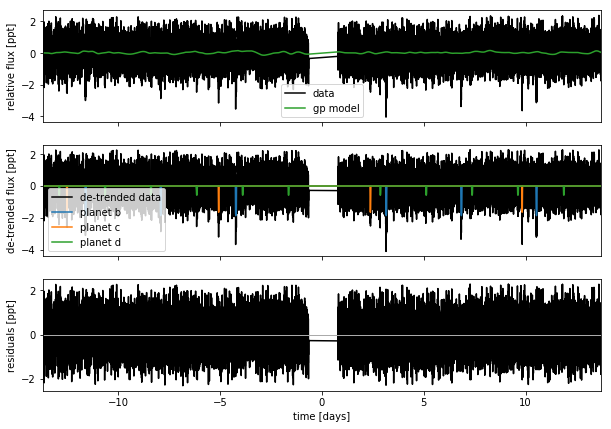

In [47]:
model, map_soln = build_model(mask, map_soln0)
plot_light_curve(model, map_soln, mask);

In [48]:
sampler = xo.PyMC3Sampler()
with model:
    burnin = sampler.tune(tune=3000, start=map_soln, step_kwargs=dict(target_accept=0.9))

/home/tom/anaconda3/envs/exoplanet/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Sampling 4 chains: 100%|██████████| 408/408 [04:50<00:00,  2.71s/draws]
The chain contains only diverging samples. The model is probably misspecified.
Sampling 4 chains: 100%|██████████| 208/208 [01:56<00:00,  1.21s/draws]


In [49]:
with model:
#     db = pm.backends.Text('l98-trace')
    trace = sampler.sample(draws=2000)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logw0, logS0, logs2, omega, ecc, b_param, logror, t0, logP, logrho_star, r_star, u_star, mean]
Sampling 4 chains: 100%|██████████| 8000/8000 [1:32:32<00:00,  2.42s/draws]
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [52]:
pm.summary(trace, varnames= ['b', 'r', 't0', 'period', 'r_star', 'u_star',  'logw0', 'logS0',
                             'logs2', 'mean', 'r_ple', 'rho_star'], alpha=0.32)

,mean,sd,mc_error,hpd_16,hpd_84,n_eff,Rhat
b__0,0.286890,0.183236,0.003132,0.009581,0.377102,2837.556978,1.000272
b__1,0.832611,0.135753,0.003117,0.829396,0.931357,1644.429646,1.001834
b__2,0.317054,0.194112,0.003076,0.038197,0.447400,3672.188782,1.001088
r__0,0.040267,0.001180,0.000020,0.039148,0.041293,3209.356792,0.999937
r__1,0.043076,0.005507,0.000201,0.039987,0.045329,704.528673,1.002496
r__2,0.022341,0.001176,0.000015,0.021083,0.023372,5726.013425,0.999838
t0__0,-0.535123,0.000370,0.000004,-0.535472,-0.534770,7026.113144,0.999874
t0__1,-5.073081,0.000734,0.000009,-5.073788,-5.072372,6710.243447,1.000036
t0__2,-1.639528,0.000915,0.000013,-1.640161,-1.638482,4977.497908,0.999818
period__0,3.690652,0.000152,0.000002,3.690525,3.690813,6736.220674,0.999844
